C:\Users\kenji\AppData\Local\Temp\ipykernel_34256\3394425590.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(impute_session)


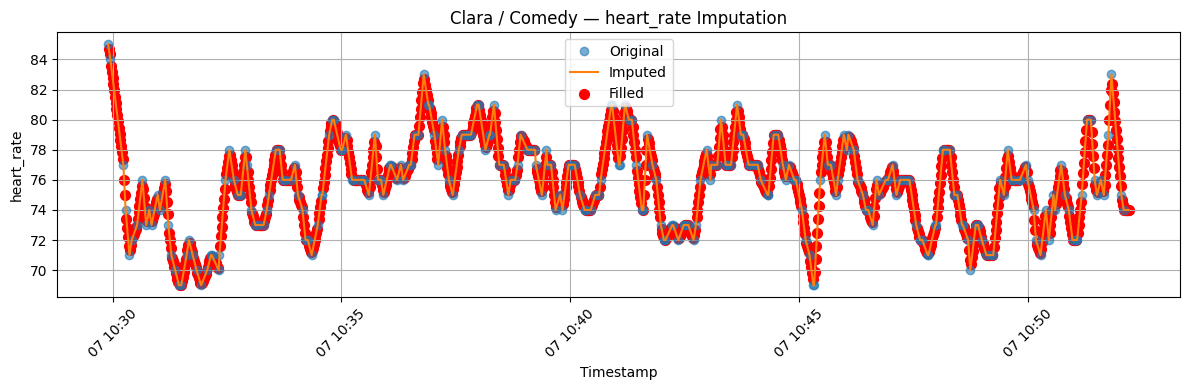

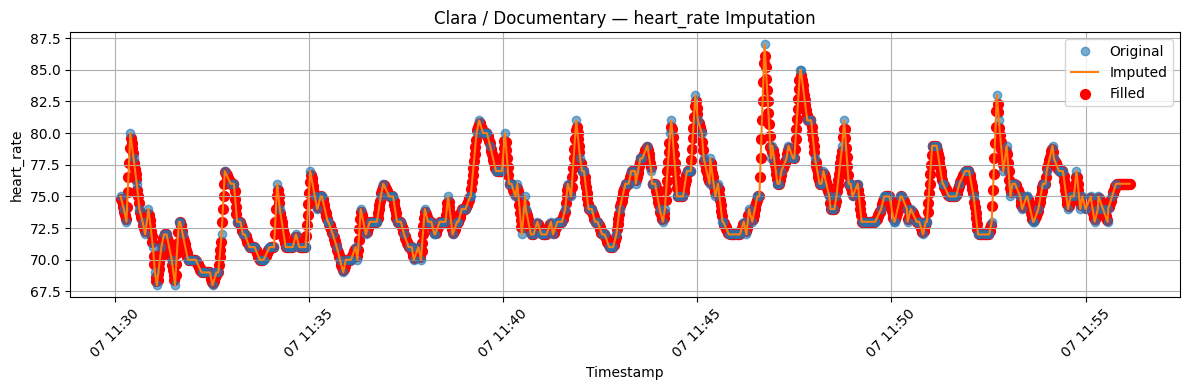

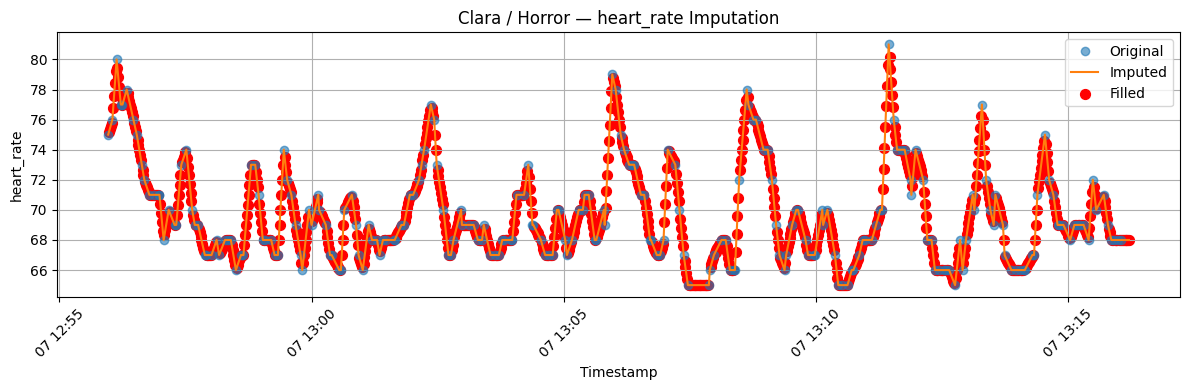

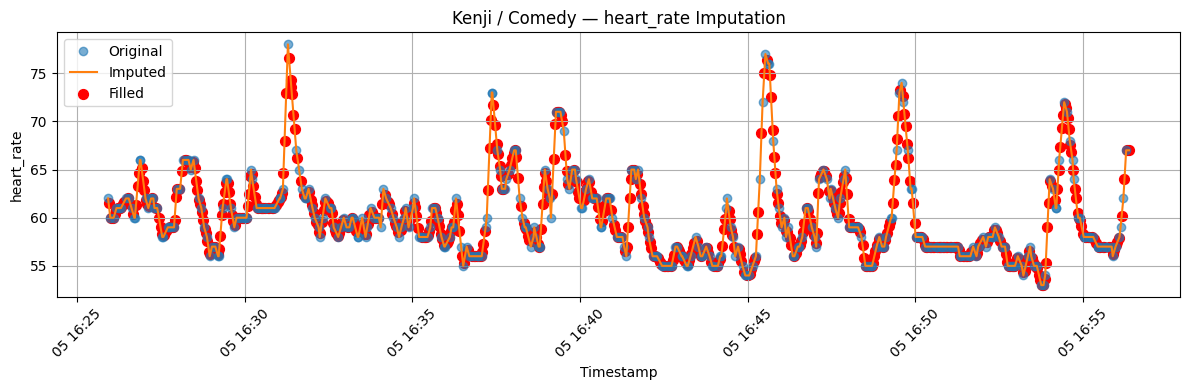

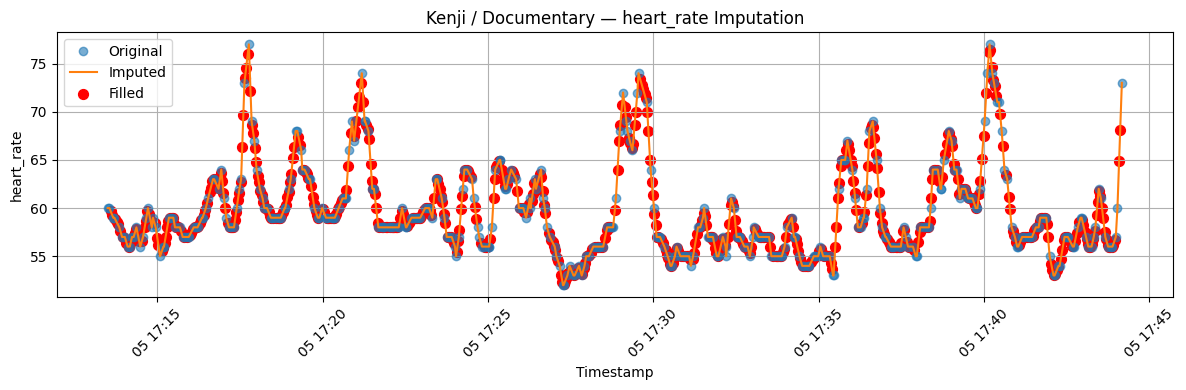

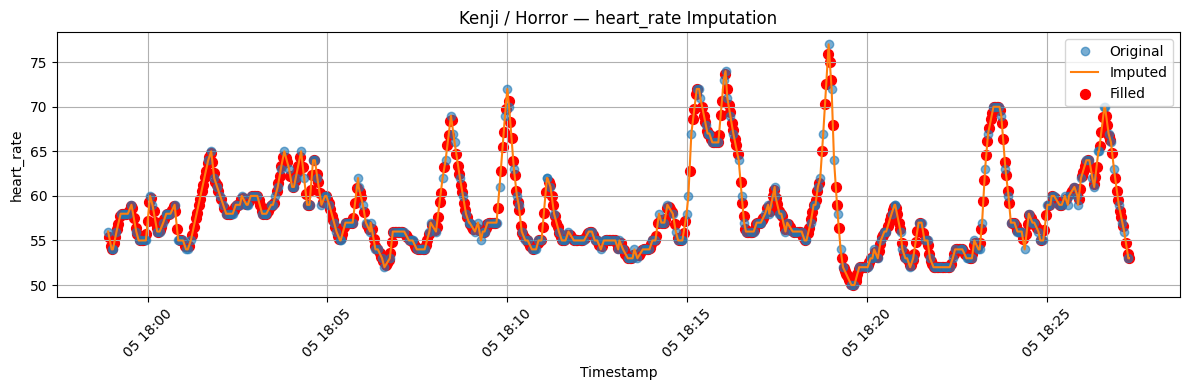

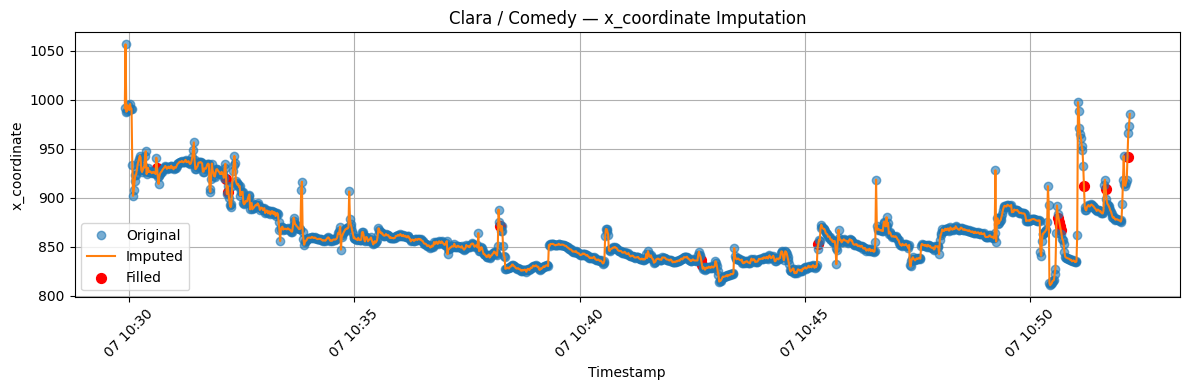

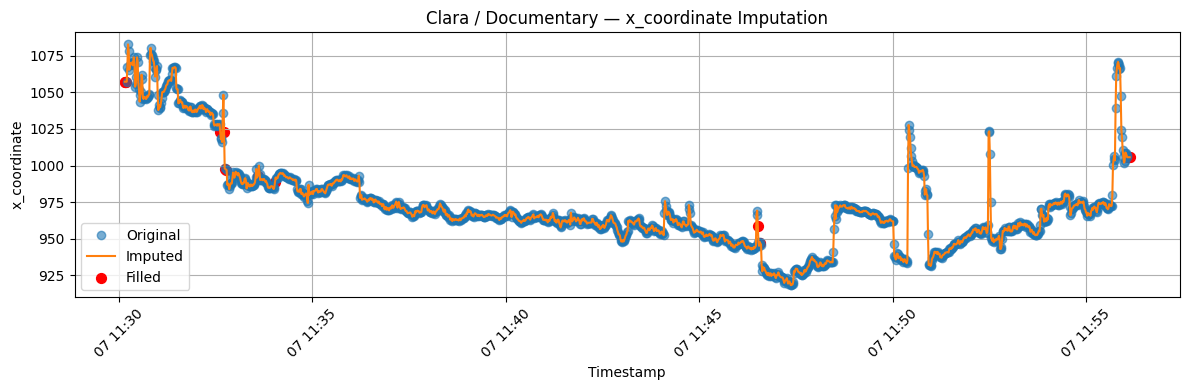

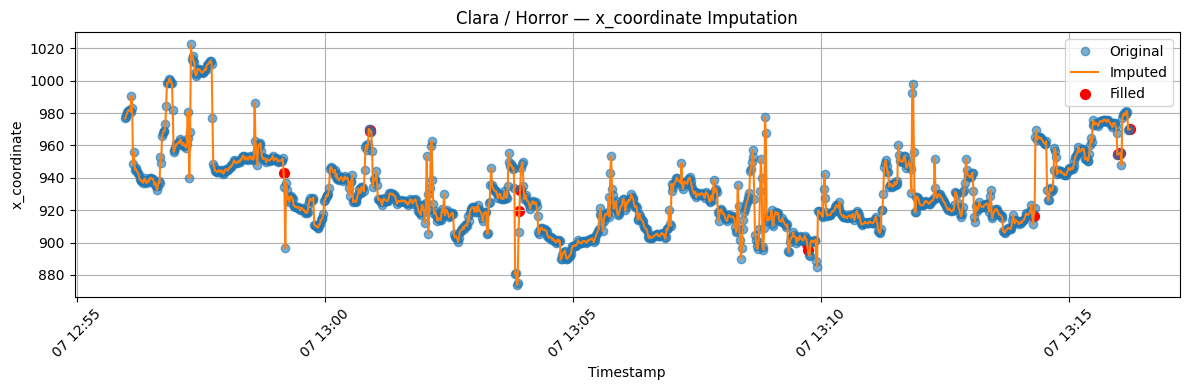

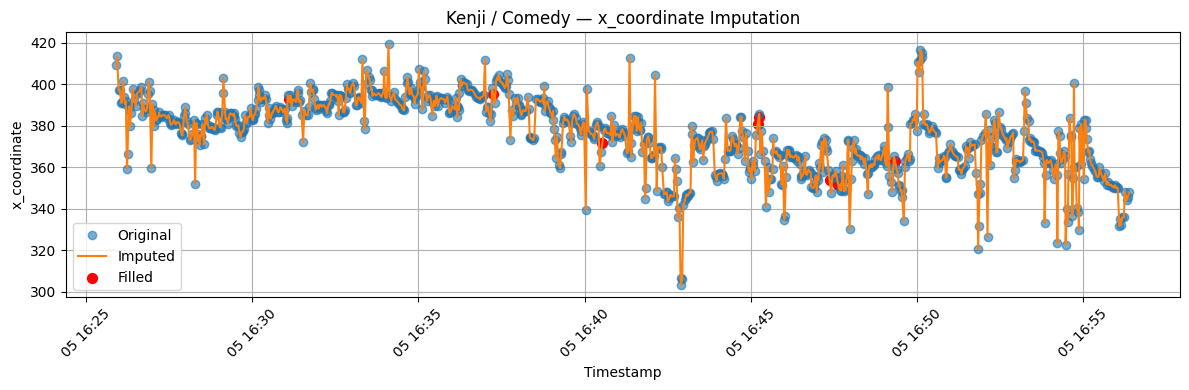

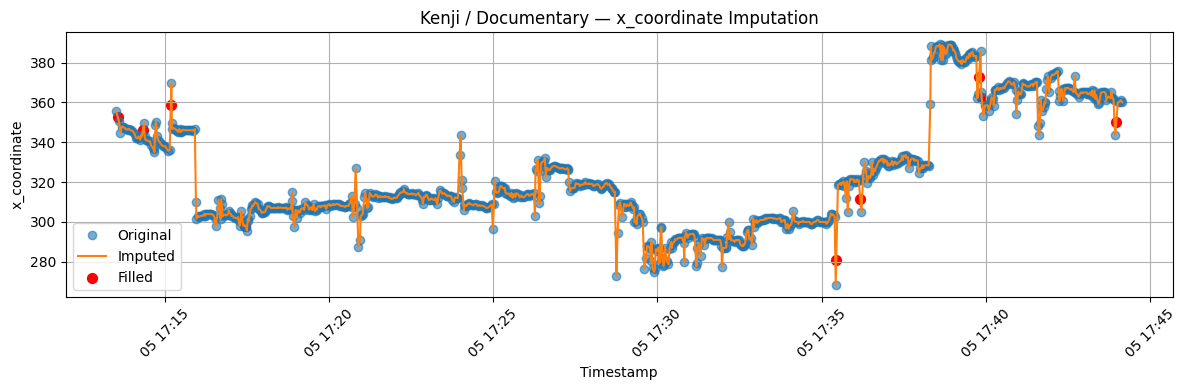

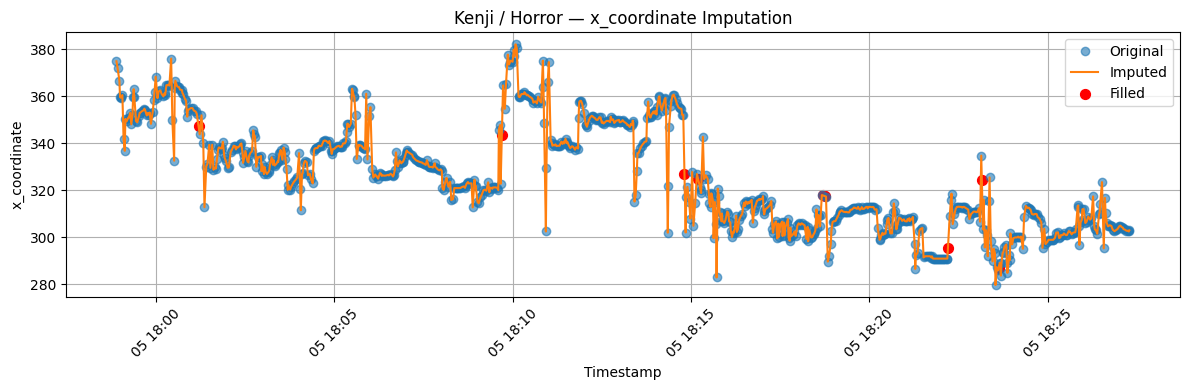

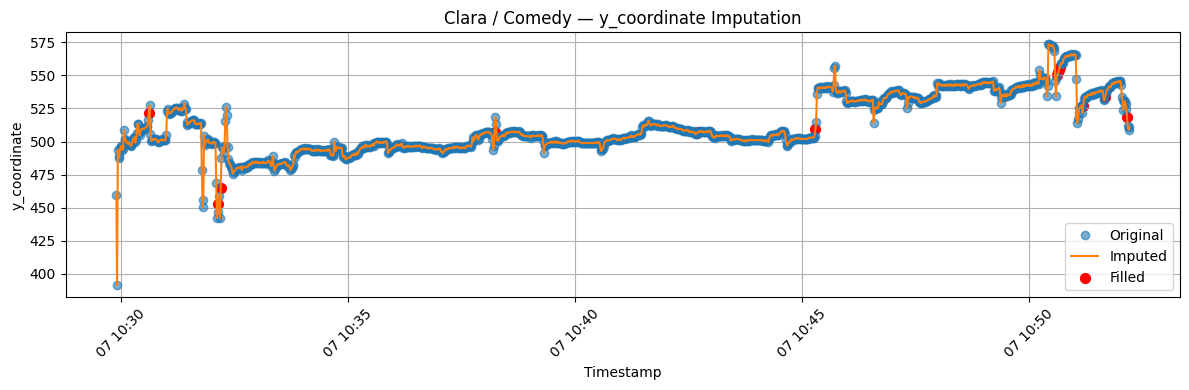

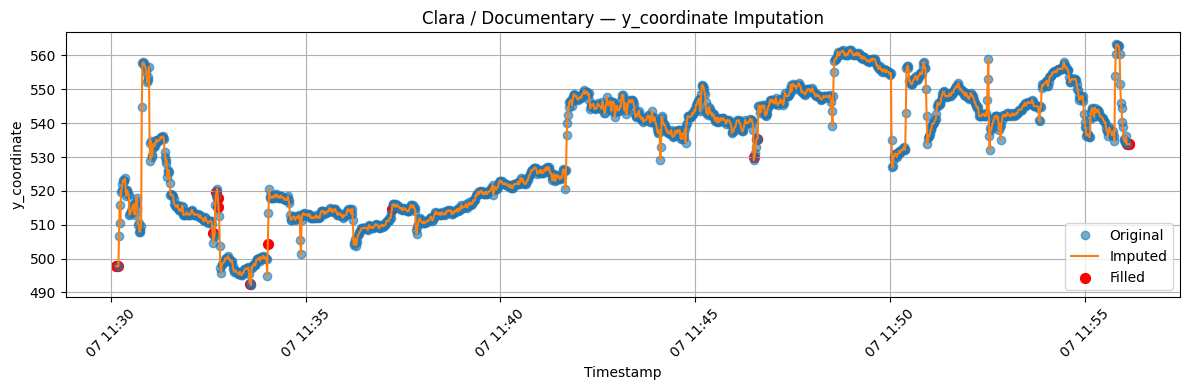

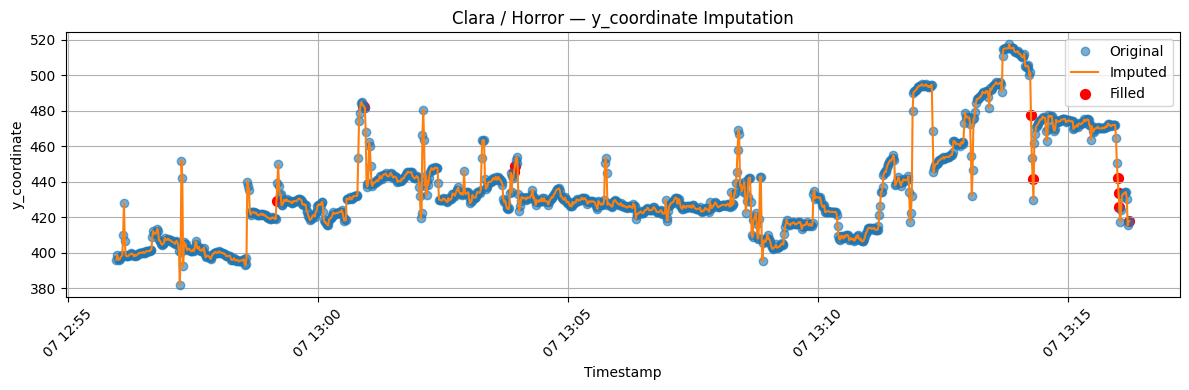

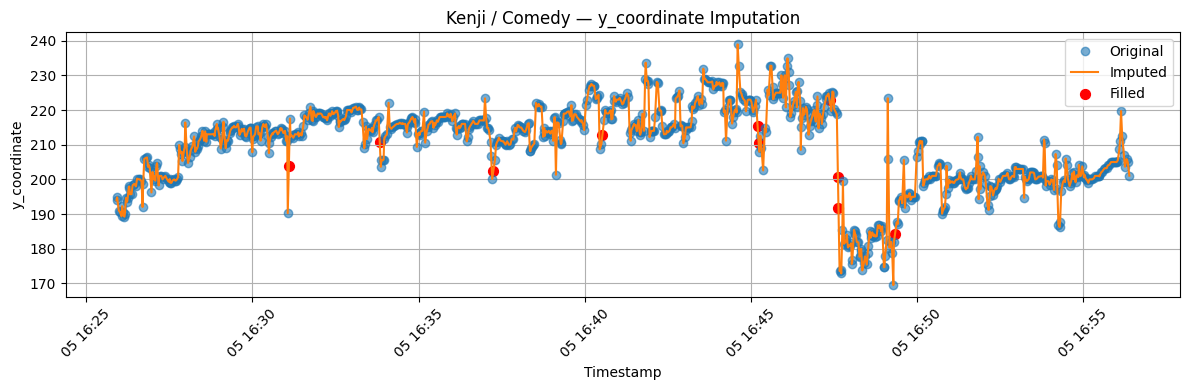

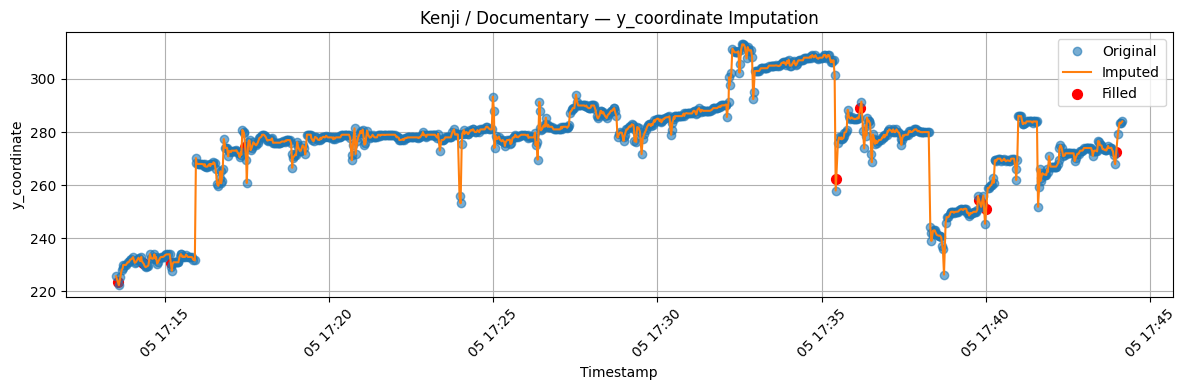

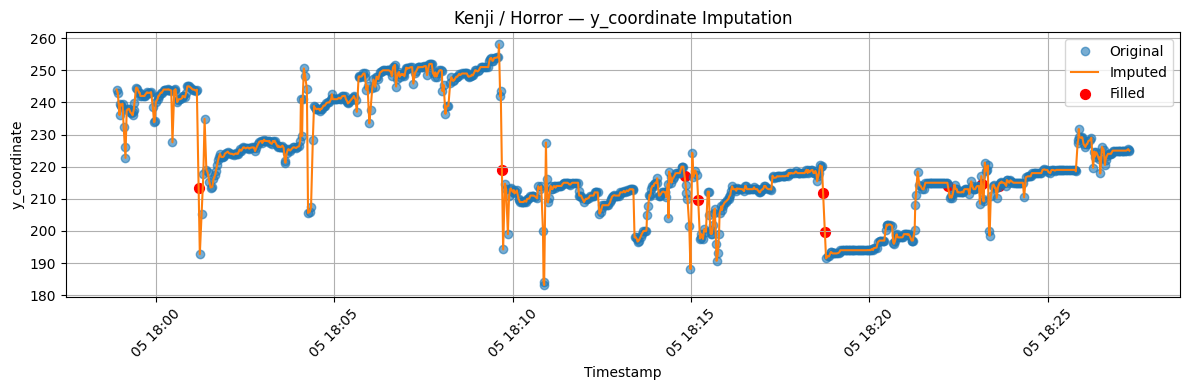

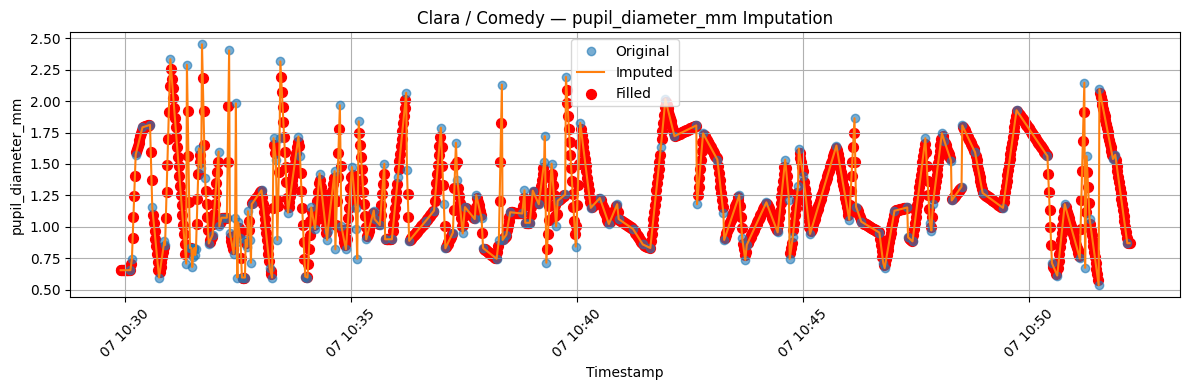

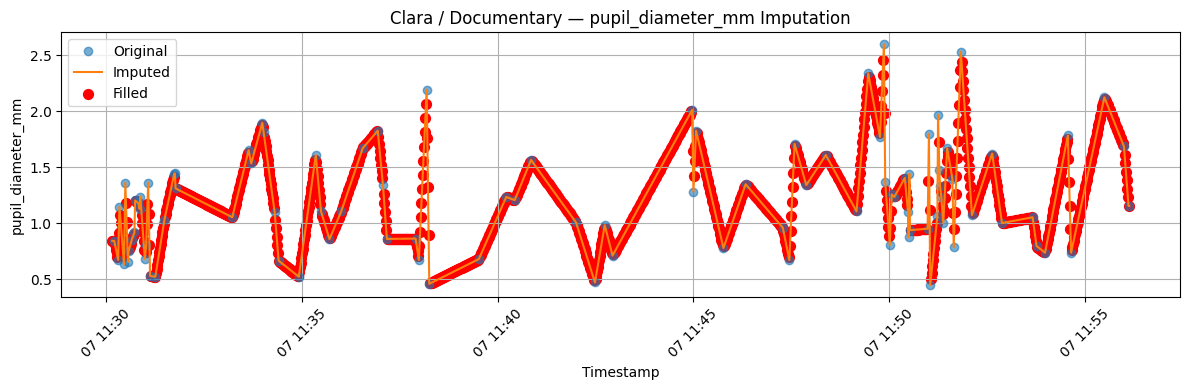

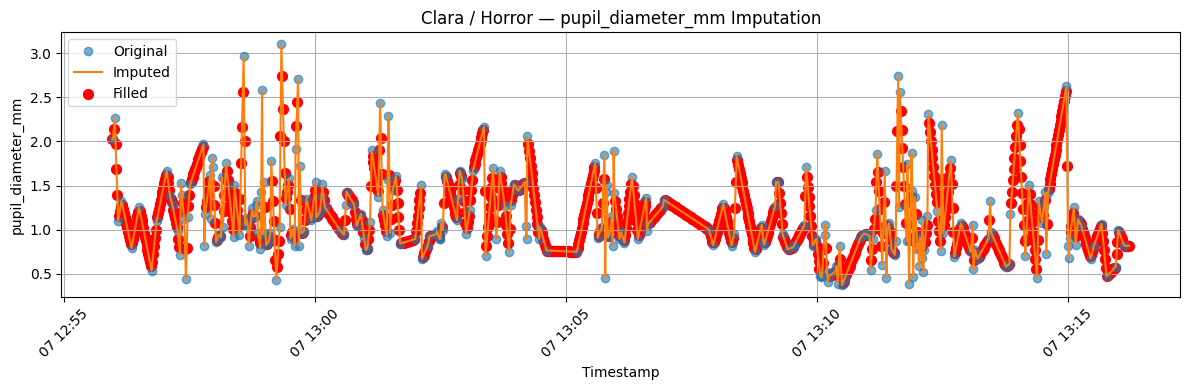

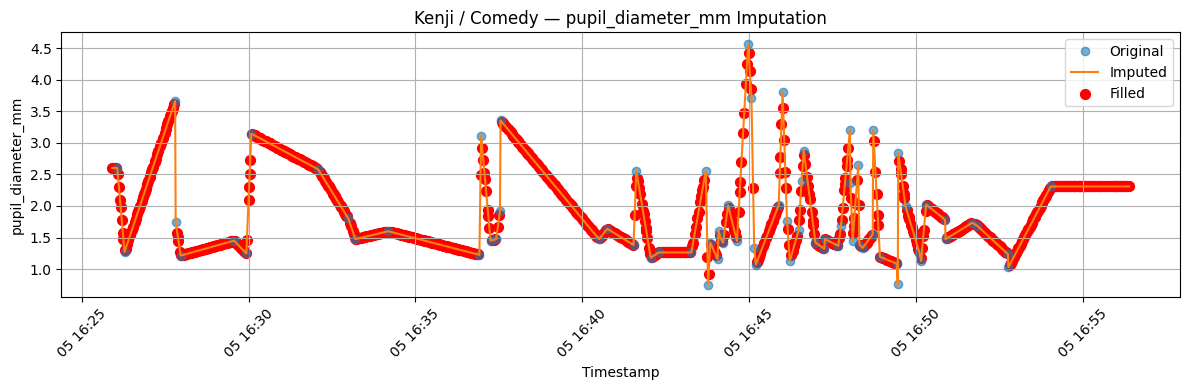

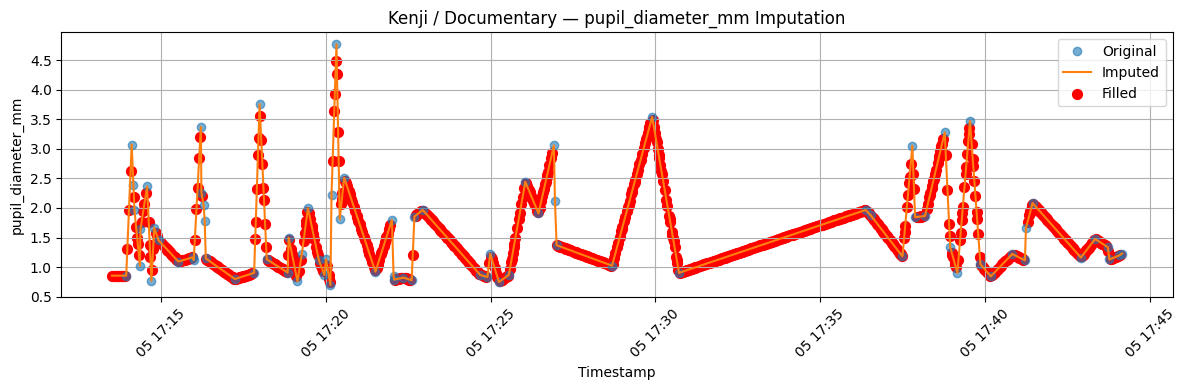

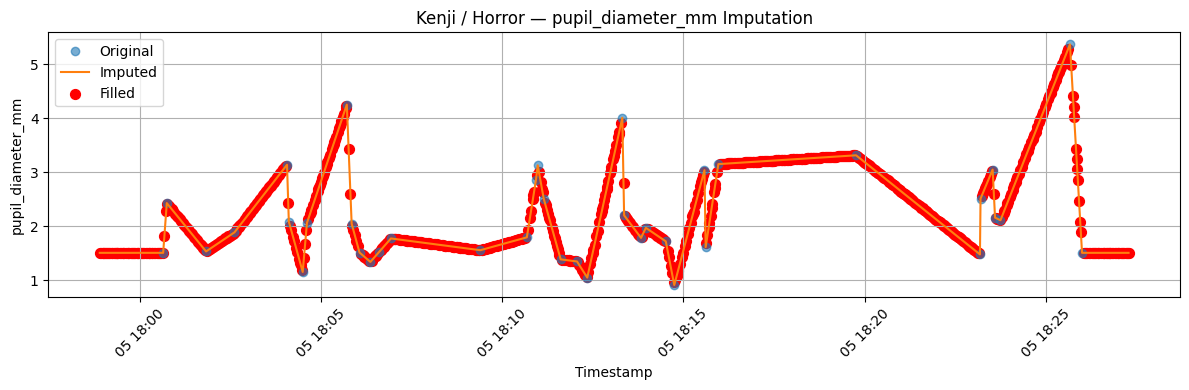

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load cleaned data
df_clean = pd.read_csv('data/cleaned_data.csv', parse_dates=['timestamp'])

# 2) Define columns to impute
to_impute = ['heart_rate','x_coordinate','y_coordinate','pupil_diameter_mm']

# 3) Impute by group in one go
def impute_session(g):
    g = g.sort_values('timestamp').set_index('timestamp')
    # 1) time‐based interpolation for all missing
    g[to_impute] = g[to_impute].interpolate(method='time')
    # 2) forward/backward‐fill any remaining NaNs at start/end
    g[to_impute] = g[to_impute].ffill().bfill()
    return g.reset_index()

# Rebuild the imputed DataFrame:
df_imputed = (
    df_clean
    .groupby(['person','genre'], group_keys=False)
    .apply(impute_session)
)

# 4) Plot imputation for each of the imputed columns
for col in to_impute:
    for (person, genre), sub_imp in df_imputed.groupby(['person','genre']):
        sub_clean = df_clean[
            (df_clean['person']==person)&(df_clean['genre']==genre)
        ][['timestamp', col]].rename(columns={col: col + '_orig'})

        # merge on timestamp so we line up orig vs imputed
        merged = pd.merge(
            sub_imp[['timestamp', col]],
            sub_clean,
            on='timestamp',
            how='left'
        )

        # only those rows where we went from NaN → a real value
        filled_mask = merged[col].notna() & merged[col + '_orig'].isna()

        plt.figure(figsize=(12,4))
        # original observed points (blue dots)
        plt.plot(
            merged['timestamp'],
            merged[col + '_orig'],
            'o',
            label='Original',
            alpha=0.6
        )
        # full imputed line (orange)
        plt.plot(
            merged['timestamp'],
            merged[col],
            '-',
            label='Imputed',
            color='C1'
        )
        # red dots exactly where NaN became filled
        plt.scatter(
            merged.loc[filled_mask, 'timestamp'],
            merged.loc[filled_mask, col],
            color='red',
            s=50,
            label='Filled'
        )

        plt.title(f'{person.capitalize()} / {genre.capitalize()} — {col} Imputation')
        plt.xlabel('Timestamp')
        plt.ylabel(col)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
# check Nan Counts
print("NaN counts after imputation:")
print(df_imputed[to_impute].isna().sum())

NaN counts after imputation:
timestamp               0
heart_rate              0
x_coordinate            0
y_coordinate            0
pupil_diameter_mm       0
iris_diameter_mm        0
pupil_iris_ratio     6147
genre                   0
person                  0
dtype: int64


In [18]:
# recalculate the iris ratio
df_imputed['pupil_iris_ratio'] = (
    df_imputed['pupil_diameter_mm'] / df_imputed['iris_diameter_mm']
)

In [19]:
df_imputed.to_csv('data/imputed_data.csv', index=False)